# **CNN-LSTM Model for Real Daily Data Clustering (365x41x41x7)**



In this project, we are dealing with climate data that comprises spatial information, time information, and scientific values. The dataset contains the value of 7 parameters for a region of 41 longitudes and 41 latitudes for 365 days in a year. 

Our goal is to create meaningful clusters of 365 days based on the values of these 7 parameters. As the data dimension is high we planned to use deep learning-based models to generate the latent representation of each day and then generate clusters for 365 days.

As our dataset has spatial and temporal features, therefore we have developed a new CNN-LSTM model that learns the spatial features first from the dataset by considering the data of each day as an image of 41x41x7 dimension. The output of the CNN model is then passed through the LSTM model to learn the temporal features and generate the final latent variables. Using the final latent variables we perform the clustering to 365 days into different groups. During the training process, we try to reduce the clustering loss by learning better latent representations.  

# **1. Model Creation:**
This CNN-LSTM model considers our daily data as an image of size 41x41x7. The model takes a 365x1x41x41x7 NumPy array as input and applies convolution layers, and max pooling layers to learn the spatial features. Then applies the LSTM layers with dropout and dense layers to learn the temporal features. The output of this model is 512 latent features for each day's data.

In [ ]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, AveragePooling2D, LSTM, Activation, ConvLSTM2D, TimeDistributed, Input
import numpy as np


def get_conv_cnn(input_batch):

  conv_model = TimeDistributed(Conv2D(64, (3,3), padding='same', activation='tanh') )(input_batch)
  conv_model = TimeDistributed(Conv2D(64, (3,3), padding='same', activation='tanh') )(conv_model)
  conv_model = TimeDistributed(MaxPool2D(pool_size=(2,2), padding='same',strides=(2,2)))(conv_model)

  conv_model = TimeDistributed(Conv2D(256, (3,3), padding='same', activation='tanh') )(conv_model)
  conv_model = TimeDistributed(MaxPool2D(pool_size=(2,2), padding='same',strides=(2,2)))(conv_model)

  conv_model = TimeDistributed(Flatten())(conv_model)

  return conv_model


def myCNNModel(input_dims):
  input_batch = Input(shape = input_dims)
  image_features = get_conv_cnn(input_batch)
  lstm_network = LSTM(512, return_sequences=True,dropout=0.1,recurrent_dropout=0.1)(image_features)
  lstm_network = keras.layers.LSTM(512, return_sequences=False,dropout=0.1,recurrent_dropout=0.1)(lstm_network)

  lstm_network = keras.layers.Dense(256,activation='relu')(lstm_network)

  full_network = keras.Model([input_batch],lstm_network)
  return full_network


In [ ]:
from time import time
import numpy as np
import keras.backend as K
from tensorflow.keras.layers import Layer, InputSpec
from keras.layers import Dense, Input, Dropout
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans


class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='normal', name='clusters') #glorot_uniform
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it. 
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class CNNModel(object):
    def __init__(self,
                 dims,
                 n_clusters=10, 
                 alpha=1.0,
                 init='glorot_uniform'):

        super(CNNModel, self).__init__()

        self.dims = dims
        #self.input_dim = dims[0]
        self.n_stacks = len(self.dims) - 1

        self.n_clusters = n_clusters
        self.alpha = alpha
        self.model_cnn = myCNNModel(self.dims);
        print("====Model created=====")

        # prepare the CNN model with cnn_layers+clustering _layer
        clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(self.model_cnn.output)
        print("====== clustering layer created ========")
        self.model = Model(inputs=self.model_cnn.input, outputs=clustering_layer)

    def pretrain(self, x, y=None, optimizer='adam', epochs=200, batch_size=256, save_dir='results/temp'):
        print('...Pretraining...')
        self.model_cnn.compile(optimizer=optimizer, loss='mse')
        print("=======Model pretraining started====")

        csv_logger = callbacks.CSVLogger(save_dir + '/pretrain_log.csv')
        cb = [csv_logger]
        if y is not None:
            class PrintACC(callbacks.Callback):
                def __init__(self, x, y):
                    self.x = x
                    self.y = y
                    super(PrintACC, self).__init__()

                def on_epoch_end(self, epoch, logs=None):
                    if int(epochs/10) != 0 and epoch % int(epochs/10) != 0:
                        return
                    feature_model = Model(self.model.input,
                                          self.model.get_layer(
                                              'encoder_%d' % (int(len(self.model.layers) / 2) - 1)).output)
                    features = feature_model.predict(self.x)
                    km = KMeans(n_clusters=len(np.unique(self.y)), n_init=20, n_jobs=4)
                    y_pred = km.fit_predict(features)
                    # print()
                    #print(' '*8 + '|==>  acc: %.4f,  nmi: %.4f  <==|' % (metrics.acc(self.y, y_pred), metrics.nmi(self.y, y_pred)))

            cb.append(PrintACC(x, y))

        # begin pretraining
        t0 = time()
        self.model_cnn.fit(x, x, batch_size=batch_size, epochs=epochs, callbacks=cb)
        print("========the model fit is executed======")
        print('Pretraining time: %ds' % round(time() - t0))
        self.model_cnn.save_weights(save_dir + '/ae_weights.h5')
        print('Pretrained weights are saved to %s/ae_weights.h5' % save_dir)
        self.pretrained = True

    def load_weights(self, weights):  # load weights of DEC model
        self.model.load_weights(weights)

    def extract_features(self, x):
        return self.model_cnn.predict(x)

    def predict(self, x):  # predict cluster labels using the output of clustering layer
        q = self.model.predict(x, verbose=0)
        return q.argmax(1)

    @staticmethod
    def target_distribution(q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def compile(self, optimizer='sgd', loss='kld'):
        self.model.compile(optimizer=optimizer, loss=loss)

    def fit(self, x, y=None, maxiter=2e4, batch_size=256, tol=1e-3,
            update_interval=140, save_dir='./results/temp'):

        print('Update interval', update_interval)
        #save_interval = int(x.shape[0] / batch_size) * 5  # 5 epochs
        save_interval = 500
        print('Save interval', save_interval)

        # Step 1: initialize cluster centers using k-means
        t1 = time()
        print('Initializing cluster centers with k-means.')
        kmeans = KMeans(n_clusters=self.n_clusters, init = 'random', n_init=30) # OMAR 20 to 30
        y_pred = kmeans.fit_predict(self.model_cnn.predict(x))
        y_pred_last = np.copy(y_pred)
        self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

        # Step 2: deep clustering
        # logging file
        import csv
        logfile = open(save_dir + '/cnn_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter','loss'])
        logwriter.writeheader()

        loss = 0
        index = 0
        index_array = np.arange(x.shape[0])
        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q = self.model.predict(x, verbose=0)
                #print("The valus of q: ", q)
                p = self.target_distribution(q)  # update the auxiliary target distribution p
                #print("The valus of p: " , p)

                # evaluate the clustering performance
                y_pred = q.argmax(1)
                #print("The valus of y_pred: ", y_pred)
                #y_pred = q
                print("#### inside iteration ### ", ite)

                # check stop criterion
                delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
                print("##### Prediction in side the iter and the delta_label is ", delta_label)
                y_pred_last = np.copy(y_pred)
                if ite > 0 and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('Reached tolerance threshold. Stopping training.')
                    logfile.close()
                    break

            # train on batch
            # if index == 0:
            #     np.random.shuffle(index_array)
            idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
            loss = self.model.train_on_batch(x=x[idx], y=p[idx])
            print("#### the loss is ", loss)
            index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

            # save intermediate model
            if ite % save_interval == 0:
                print('saving model to:', save_dir + '/CNN_model_' + str(ite) + '.h5')
                self.model.save_weights(save_dir + '/CNN_model_' + str(ite) + '.h5')

            ite += 1

        # save the trained model
        logfile.close()
        print('saving model to:', save_dir + '/CNN_model_final.h5')
        self.model.save_weights(save_dir + '/CNN_model_final.h5')

        return y_pred

In [ ]:
import netCDF4
import netCDF4 as nc
import pandas as pd
import numpy as np
import xarray as xr
import datetime
import datetime as dt
from netCDF4 import date2num,num2date
from math import sqrt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
rdata_daily = xr.open_dataset('/content/drive/MyDrive/ERA5_meteo_sfc_2021_daily.nc')#.rename({'latitude':'lat','longitude':'lon'})
#rdata_daily = rioxarray.open_rasterio('/content/drive/MyDrive/ERA5_meteo_sfc_2021_daily.nc').rename({'y':'lon','x':'lat'})
rdata_daily

<xarray.Dataset>
Dimensions:    (time: 365, longitude: 41, latitude: 41)
Coordinates:
  * time       (time) datetime64[ns] 2021-01-01 2021-01-02 ... 2021-12-31
  * longitude  (longitude) float32 -33.0 -32.75 -32.5 ... -23.5 -23.25 -23.0
  * latitude   (latitude) float32 43.0 42.75 42.5 42.25 ... 33.5 33.25 33.0
Data variables:
    sp         (time, latitude, longitude) float64 ...
    sst        (time, latitude, longitude) float64 ...
    u10        (time, latitude, longitude) float64 ...
    v10        (time, latitude, longitude) float64 ...
    sshf       (time, latitude, longitude) float64 ...
    slhf       (time, latitude, longitude) float64 ...
    t2m        (time, latitude, longitude) float64 ...
Attributes:
    title:          Daily variables from ERA5 hourly data
    history:        Wed Mar 23 12:01:11 2022: ncrcat ERA5_meteo_sfc_2021_01-0...
    Input dataset:  /global/cscratch1/sd/xzheng/ENA/rawdata/ERA5_meteo_sfc_20...
    NCO:            netCDF Operators version 5.0.1 (Homepage = http://nco.sf....

In [ ]:
rdata_daily_np_array = np.array(rdata_daily.to_array())

# **2.Data preparation**
Our daily data have some NaN values in the SST variable. To replace these NaN values I have used the mean value of the longitude and latitude of that day. The function returns 2 NumPy arrays one with size (365, 11767) and another with size (365, 1, 41, 41, 7). The array with size (365, 11767) is used to calculate the silhouette score and the rray with size (365, 1, 41, 41, 7) is used to train the model.

In [ ]:
## This function will will pre-process our daily data for DEC model as numpy array
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

def data_preprocessing(data_path):
  rdata_daily = xr.open_dataset(data_path)    # data_path = '/content/drive/MyDrive/ERA5_meteo_sfc_2021_daily.nc'
  rdata_daily_np_array = np.array(rdata_daily.to_array())   # the shape of the dailt data is (7, 365, 41, 41)
  rdata_daily_np_array_T = rdata_daily_np_array.transpose(1,0,2,3)   # transform the dailt data from (7, 365, 41, 41) to (365, 7, 41, 41)
  for i in range(rdata_daily_np_array_T.shape[0]):
    for j in range(rdata_daily_np_array_T.shape[1]):
      for k in range(rdata_daily_np_array_T.shape[2]):
        for l in range(rdata_daily_np_array_T.shape[3]):
          if np.isnan(rdata_daily_np_array_T[i, j, k, l]):
            #print("NAN data in ", i, j, k, l)
            rdata_daily_np_array_T[i, j, k, l]=np.nanmean(rdata_daily_np_array_T[i, j, k, :])
  rdata_daily_np_array_T = rdata_daily_np_array_T.transpose(0,2,3,1)
  rdata_daily_np_array_T_R = rdata_daily_np_array_T.reshape((rdata_daily_np_array_T.shape[0], -1))  # transform the dailt data from (365, 7, 41, 41) to (365, 11767)
  min_max_scaler = preprocessing.MinMaxScaler() # calling the function
  rdata_daily_np_array_T_R_nor = min_max_scaler.fit_transform(rdata_daily_np_array_T_R)   # now normalize the data, otherwise the loss will be very big 
  #rdata_daily_np_array_T_R_nor = np.float32(rdata_daily_np_array_T_R_nor)    # convert the data type to float32, otherwise the loass will be out-of-limit 
  rdata_daily_np_array_T_R_nor_R = rdata_daily_np_array_T_R_nor.reshape((rdata_daily_np_array_T_R_nor.shape[0], 41,41,7))
  rdata_daily_np_array_T_R_nor_new = rdata_daily_np_array_T_R_nor_R.reshape(rdata_daily_np_array_T_R_nor_R.shape[0], 1, 41, 41, 7)
  return rdata_daily_np_array_T_R_nor, rdata_daily_np_array_T_R_nor_new


In [ ]:
data_nor_eval, data_clustering = data_preprocessing('/content/drive/MyDrive/ERA5_meteo_sfc_2021_daily.nc')

In [ ]:
data_nor_eval.shape, data_clustering.shape

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
def silhouette_score(X, labels, *, metric="cosine", sample_size=None, random_state=None, **kwds):  
 return np.mean(silhouette_samples(X, labels, metric="cosine", **kwds))

## **3. Model Training**
This function defines related parameters to train the model. Then instantiate the model and train on the pre-processed data. The model tries to optimize the clustering loss. After training the model returns the cluster results. 

In [ ]:
def main():

    batch_size = 366
    maxiter = 2e4
    pretrain_epochs = 3
    update_interval = 50
    tol = 0.0000001
    ae_weights = None
    save_dir = '/content/drive/MyDrive/My_CNN_result_2'


    x = data_clustering
    y = None
    n_clusters = 7


    init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')
    pretrain_optimizer = SGD(learning_rate=0.1, momentum=0.9)
    # setting parameters

    # prepare the DEC model
    cnnmodel = CNNModel(dims=(1,41,41,7), n_clusters=n_clusters, init=init)


    cnnmodel.model.summary()
    t0 = time()
    cnnmodel.compile(optimizer=SGD(0.0000001, 0.9), loss='kld')#mse    kld
    y_pred = cnnmodel.fit(x, y=y, tol=tol, maxiter=maxiter, batch_size=batch_size,
                     update_interval=update_interval, save_dir=save_dir)
    #print('acc:', metrics.acc(y, y_pred))
    print('clustering time: ', (time() - t0))
    return y_pred

In [ ]:
res = main()
res

====Model created=====
====== clustering layer created ========
Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 1, 41, 41, 7)]    0         
                                                                 
 time_distributed_143 (TimeD  (None, 1, 41, 41, 64)    4096      
 istributed)                                                     
                                                                 
 time_distributed_144 (TimeD  (None, 1, 41, 41, 64)    36928     
 istributed)                                                     
                                                                 
 time_distributed_145 (TimeD  (None, 1, 21, 21, 64)    0         
 istributed)                                                     
                                                                 
 time_distributed_146 (TimeD  (None, 1, 21, 21, 256)   14771

array([6, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 2, 2, 6,
       6, 2, 2, 2, 2, 2, 2, 6, 6, 2, 4, 4, 4, 6, 6, 6, 2, 2, 2, 2, 2, 2,
       4, 4, 6, 6, 2, 4, 4, 2, 2, 4, 6, 6, 6, 6, 6, 6, 2, 2, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2,
       3, 3, 6, 3, 3, 3, 3, 3, 3, 6, 6, 3, 3, 2, 2, 6, 6, 6, 6, 6, 6, 2,
       2, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 6, 6, 6, 6,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1,
       5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
u,indices = np.unique(res,return_counts = True)
u,indices 

In [ ]:
silhouette_avg_rdata_daily = silhouette_score(data_nor_eval, res)  
print("The average silhouette_score is :", silhouette_avg_rdata_daily)

## **4. Visualization and Evaluation:**
To visualize the clustering results I have downloaded the GitHub repository in ZIP format from https://github.com/big-data-lab-umbc/multivariate-weather-data-clustering this link and uploaded the ZIP folder to the Google Colab memory. Then unzipped it, and used the visualization and evaluation methods.  

In [ ]:
!unzip /content/multivariate-weather-data-clustering-main.zip

In [ ]:
!mv multivariate-weather-data-clustering-main multivariateweatherdataclusteringmain

In [ ]:
from multivariateweatherdataclusteringmain.MWDC.Visualization.Visualization import visualization

In [ ]:
df=pd.DataFrame()
df1=pd.DataFrame()
df['time_step'] = np.arange(len(res))
df['clusterid'] = pd.DataFrame(res)
df.to_csv('/content/drive/MyDrive/my-cnn-rnn-result_0.34.csv',index=True)

total clusters:  7
varid: sst
var_range: [286.9919318332959, 299.0668423730597]


/content/multivariateweatherdataclusteringmain/MWDC/Visualization/Visualization.py:131: RuntimeWarning: Mean of empty slice
  var_mean_icluster = np.nanmean(var_icluster,axis=0)
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/content/multivariateweatherdataclusteringmain/MWDC/Visualization/Visualization.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.subplot(panel)
/content/multivariateweatherdataclusteringmain/MWDC/Visualization/Visualization.py:74: UserWarning: The following kwargs were not used by contour: 'linewidth'
  p1=ax.contour(lon0,lat0,var,cmap=cmap0,levels=np.arange(var_range[0],var_range[

varid: t2m
var_range: [-0.08280723076385484, -0.07839707801928061]
varid: u10
var_range: [-15.129702662479593, 16.82725476413482]
varid: v10
var_range: [-14.294945017569995, 14.039669939743764]
varid: sshf
var_range: [-43.41541985801895, 175.22246693947238]
varid: sp
var_range: [985.3787786916515, 1035.1150602330122]


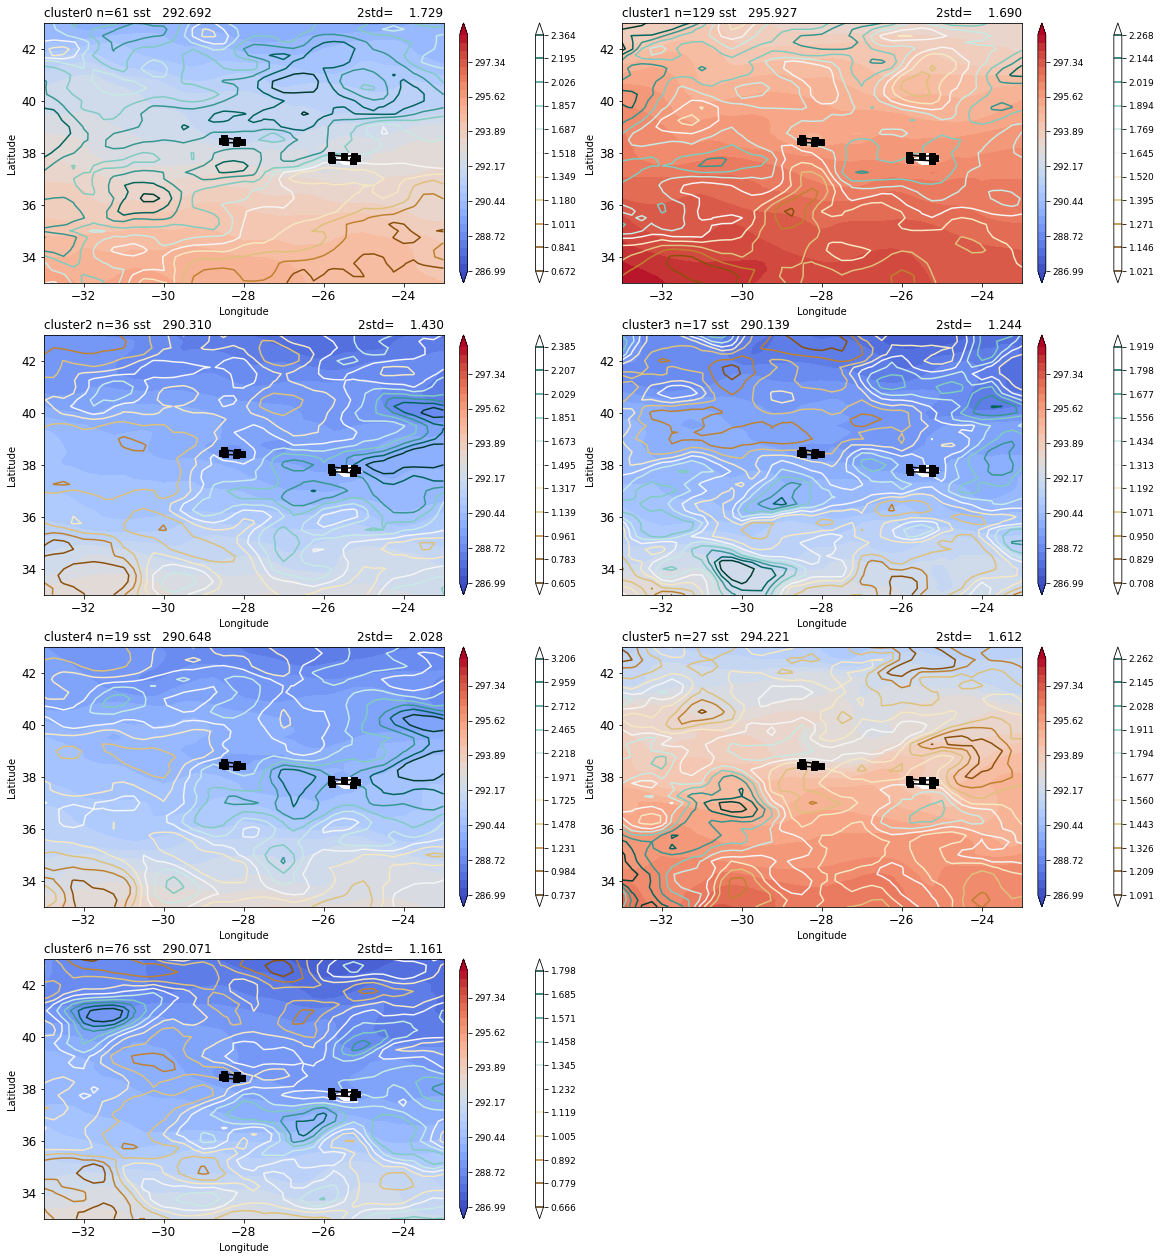

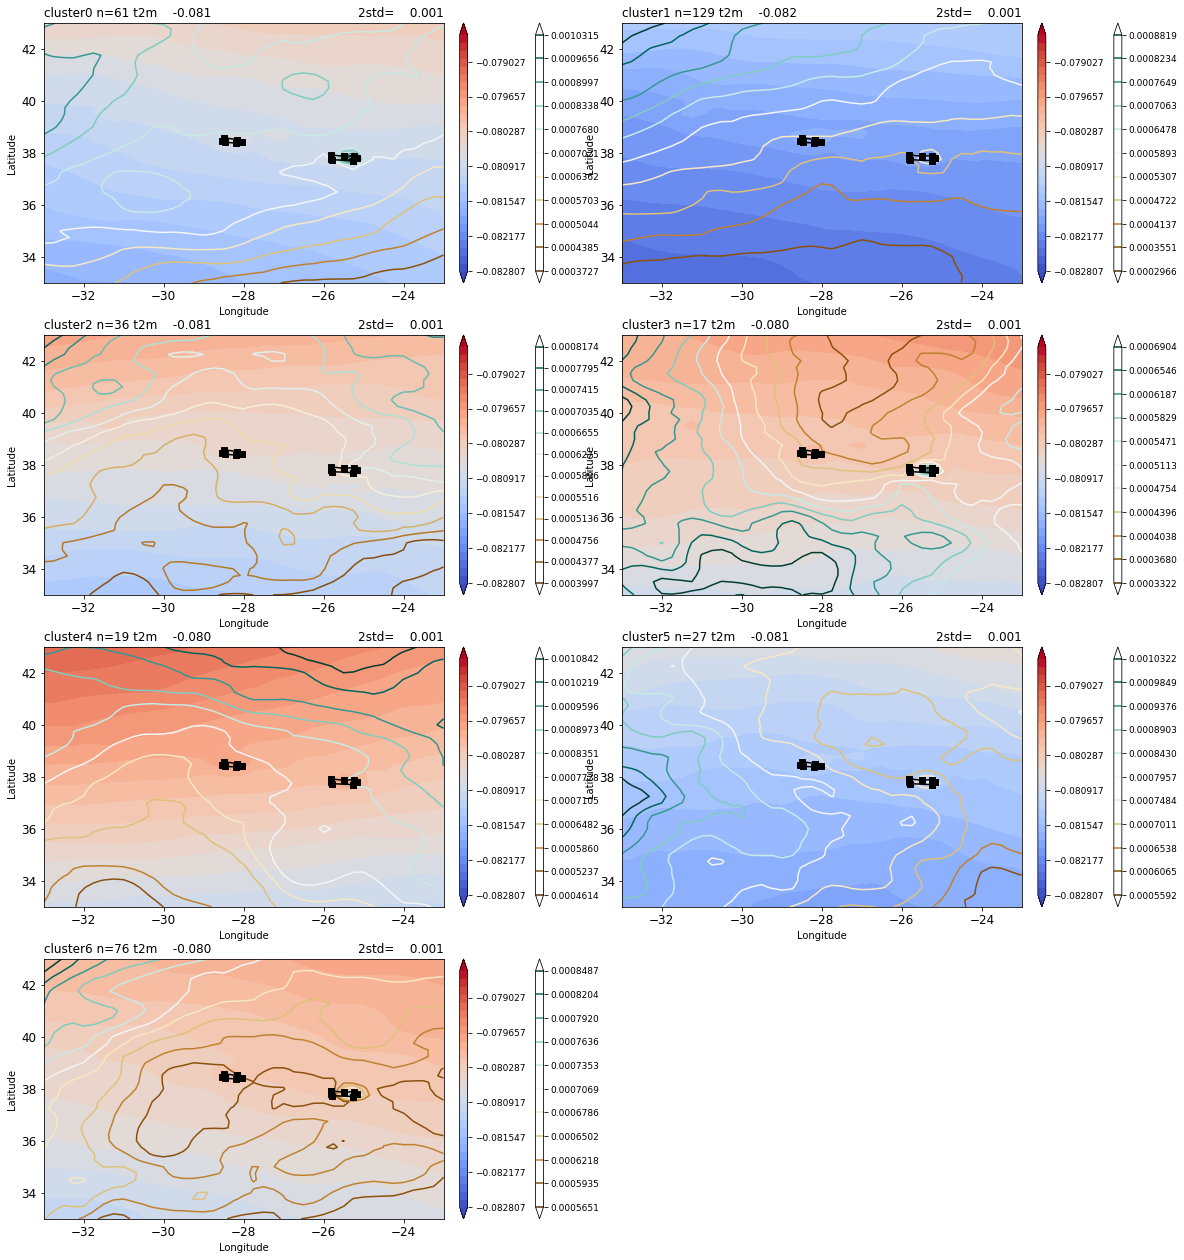

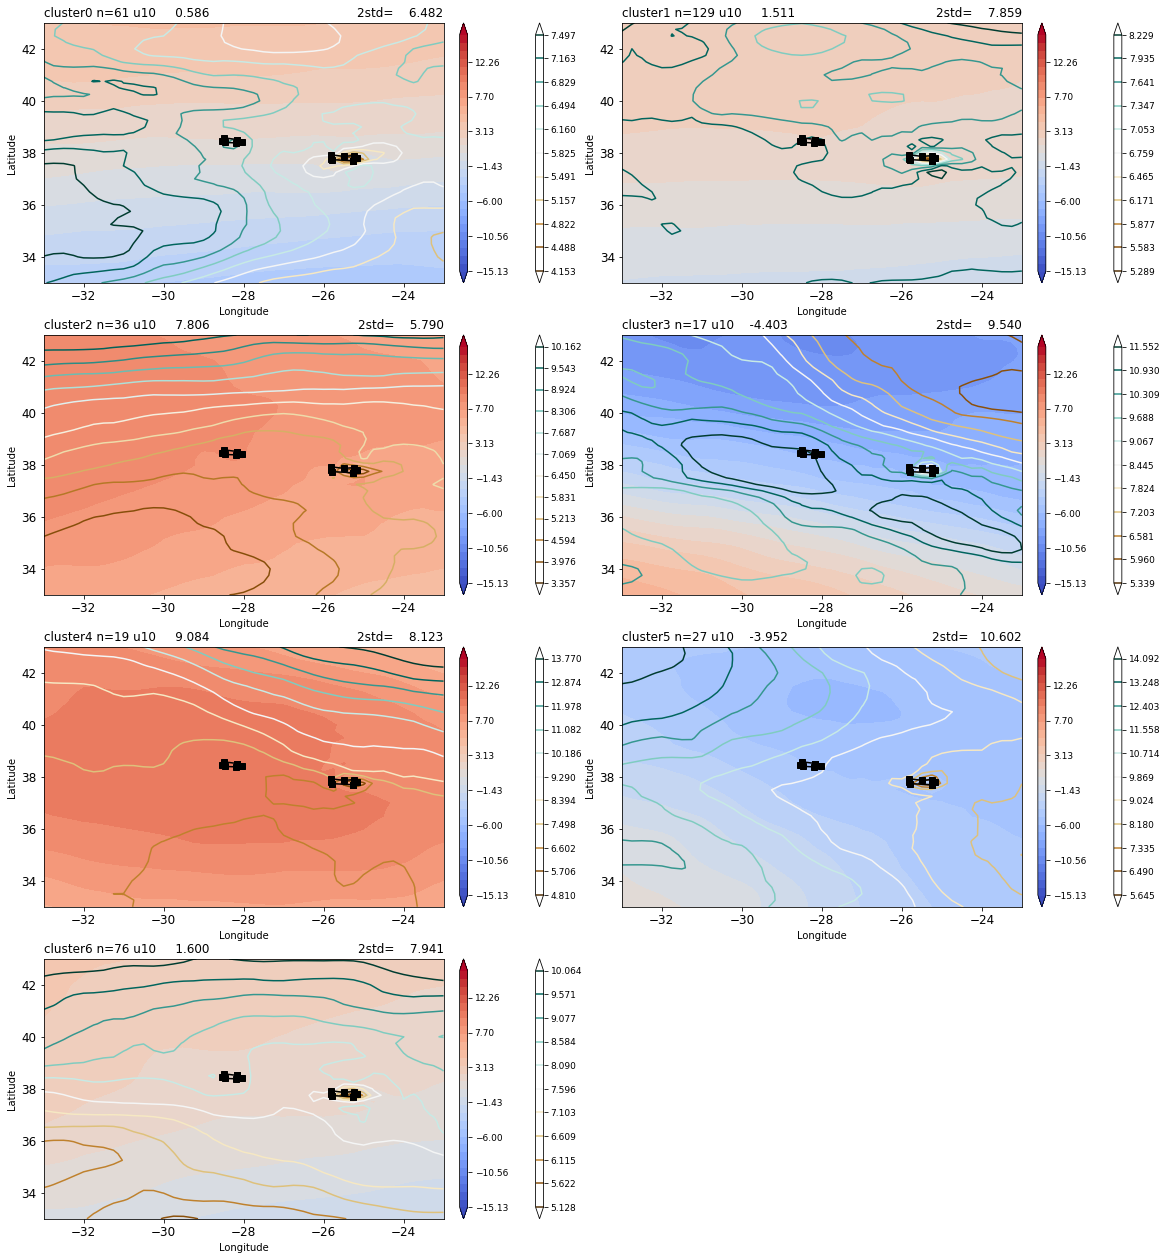

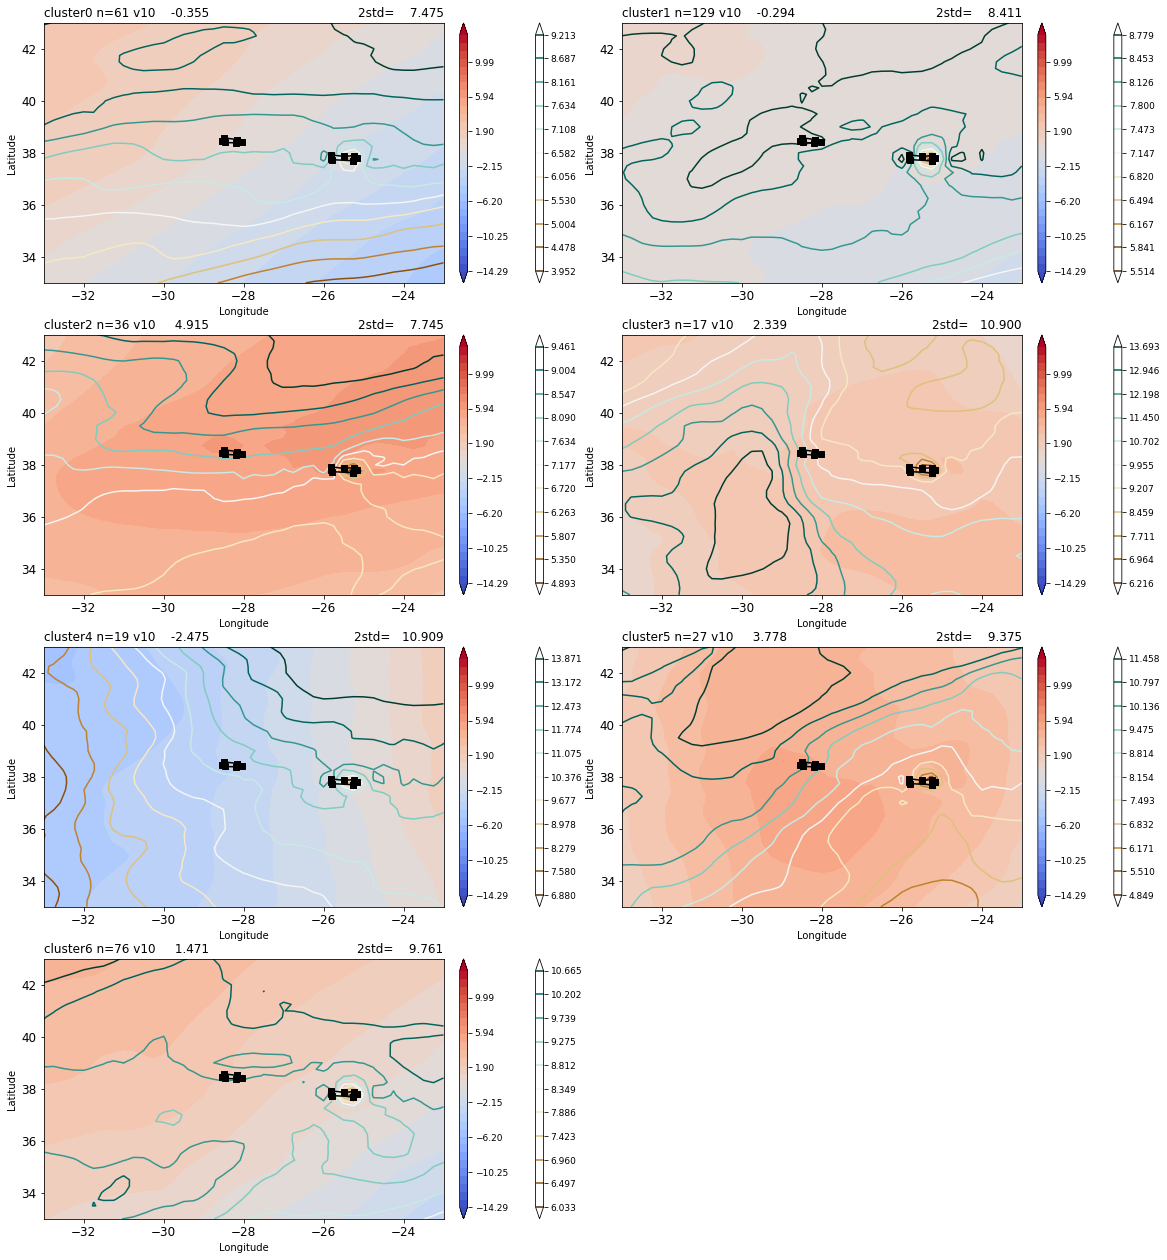

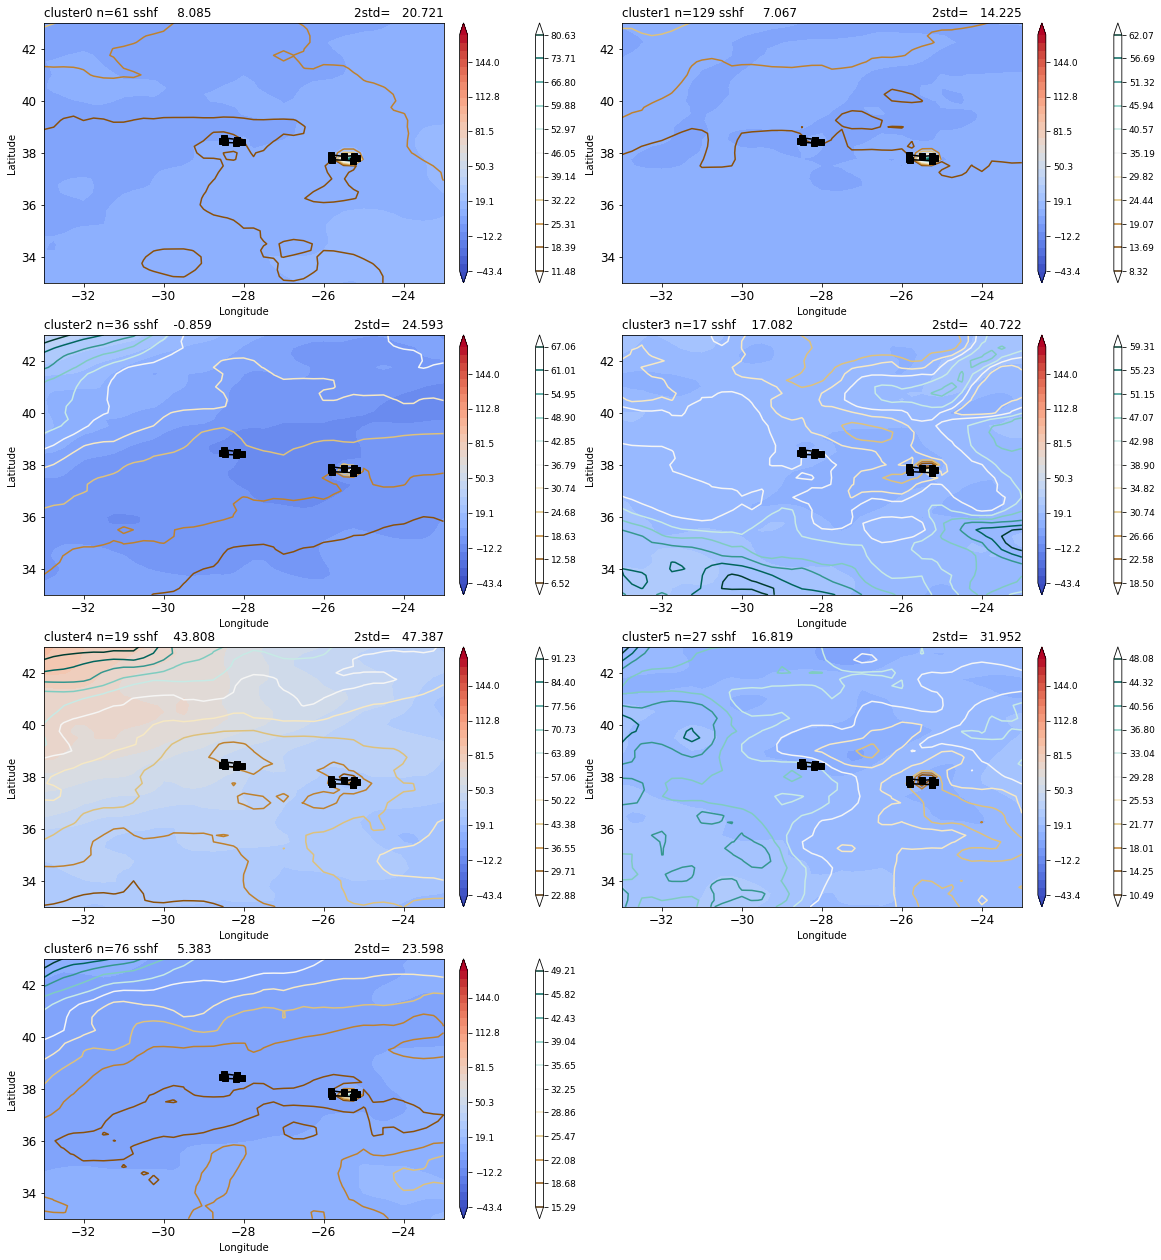

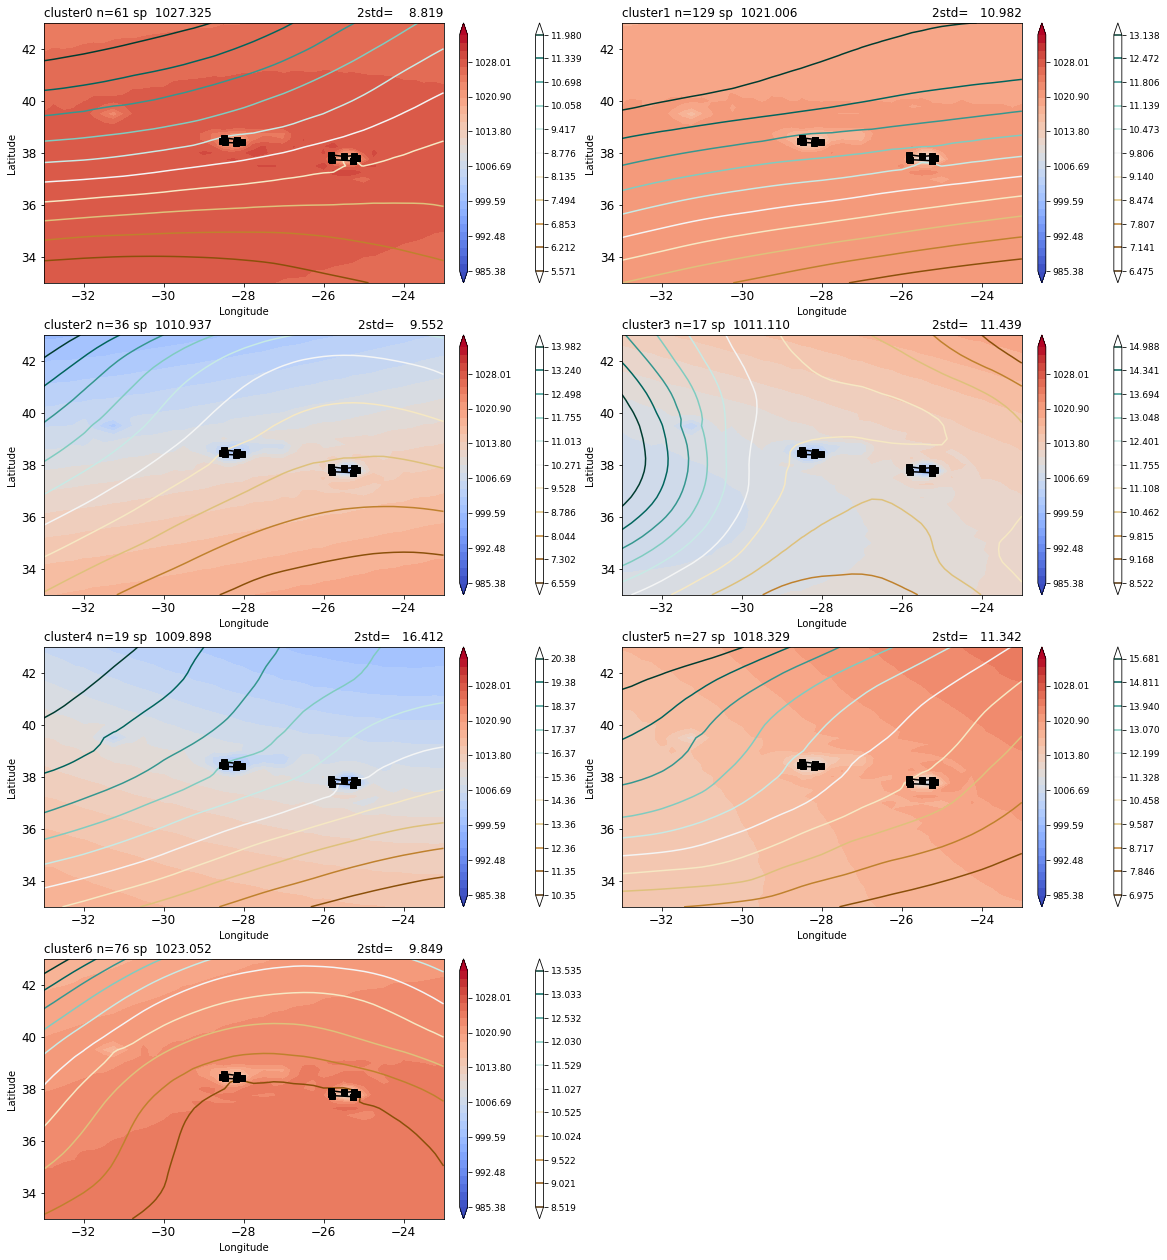

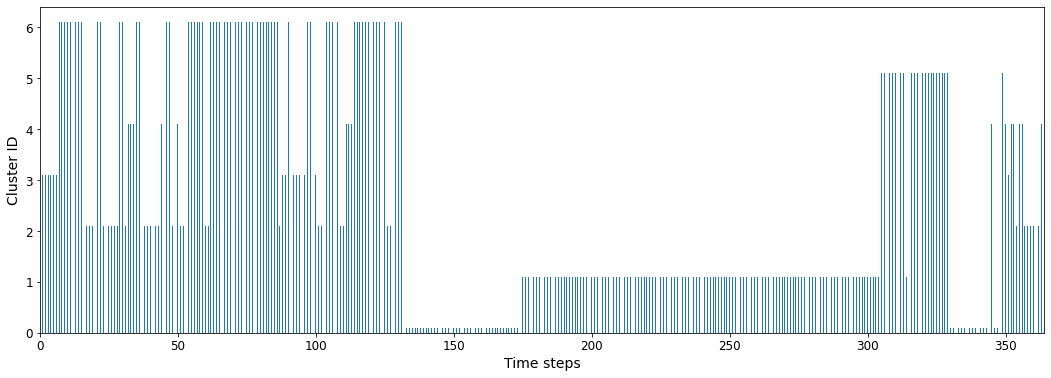

In [ ]:
visualization('/content/drive/MyDrive/ERA5_meteo_sfc_2021_daily.nc' ,'/content/drive/MyDrive/my-cnn-rnn-result_0.34.csv', '/content/multivariateweatherdataclusteringmain/MWDC/Visualization/coast.txt')

In [ ]:
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc
from sklearn import preprocessing
from statistics import mean
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

from multivariateweatherdataclusteringmain.MWDC.preprocessing import *

input = datatransformation(rdata_daily)

input = datanormalization(input)

input['Cluster'] = res

In [ ]:
from multivariateweatherdataclusteringmain.MWDC.Evaluation.sp_evaluation_2 import *

In [ ]:
trans_data = input

In [ ]:
st_rmse(input, formed_clusters)

NameError: ignored